https://towardsdatascience.com/predictive-maintenance-with-lstm-siamese-network-51ee7df29767

https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07

https://github.com/likejazz/Siamese-LSTM

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno
import time

from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import tensorflow
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, Lambda, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import tensorflow.keras.backend as K

In [2]:
df = pd.read_csv("train_data.csv")

timestep = 17 #from 1 to 23 (17 with the current NaN strategy)
threshold_for_classification = -7.
fill_X = 1.1
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11

#RNN hiperparameter
epochs = 20
batch = 512
val_split = 0.25
test_split = 0.25
shuffle = True
loss = 'binary_crossentropy'
optimizer = optimizers.Nadam(learning_rate=0.0005, clipnorm=1.) #(learning_rate=0.002)
class_weight = {True:  1.,
                False: 0.05}
verbose = 1

In [3]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns

X = np.zeros((events,timestep,features))
X.fill(fill_X)

i = 0
def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of zeros.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)

(7311, 17, 124) (7311, 1)


In [4]:
#computing scaled threshold 
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#Splitting arrays
y_boolean = (y > threshold_scaled).reshape(-1,1)
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y, 
                                                    stratify=y_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = test_split
                                                  )

y_train_boolean = (y_train_numeric > threshold_scaled).reshape(-1,1)
X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(X_train, y_train_numeric, 
                                                    stratify=y_train_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = val_split
                                                  )
#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_val = (y_val_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#Percentage of high risks in train
print("TRAIN {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_train), y_train.shape[0], np.sum(y_train)/y_train.shape[0]))
#Percentage of high risks in val
print("VAL   {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_val), y_val.shape[0], np.sum(y_val)/y_val.shape[0]))
#Percentage of high risks in test
print("TEST  {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_test), y_test.shape[0], np.sum(y_test)/y_test.shape[0]))

TRAIN 117.0, 4112.0, 0.028
VAL   39.0, 1371.0, 0.028
TEST  52.0, 1828.0, 0.028


In [5]:
#Sampling pairs

def get_samples(X, y):
    
    #Initializing input and output arrays
    
    X_true = X[np.where(y==True)[0],:,:]
    X_false = X[np.where(y==False)[0],:,:]
    X_quarter = X_true.shape[0]*X_true.shape[0]
    
    X_left = np.zeros((X_quarter*4, X_true.shape[1], X_true.shape[2]))
    X_right = np.zeros((X_quarter*4, X_true.shape[1], X_true.shape[2]))
    y_pairs = np.zeros((X_quarter*4,1))
        
    # First 1/4 -> Left: X_true Right: X_true y: True
    
    l = X_true.shape[0]
    
    for i in range(l):
        for j in range(l):
            X_left[j+i*l] = X_true[i]
            X_right[j+i*l] = X_true[j]
        
    # Second 1/4 -> Left: X_false Right: X_false y: True
    
    idx_left = np.random.randint(X_false.shape[0], size=X_quarter)
    idx_right = np.random.randint(X_false.shape[0], size=X_quarter)
    
    X_left[X_quarter:X_quarter*2] = X_false[idx_left]
    X_right[X_quarter:X_quarter*2] = X_false[idx_right]
        
    # Third 1/4 ->  Left: X_true Right: X_false y: False
    # Fourth 1/4 -> Left: X_false Right: X_true y: False
    
    l = X_true.shape[0] #length of the slice and the loop so l*l = 1/4
    o_2 = X_quarter*2 #offset for third 1/4
    o_3 = X_quarter*3 #offset for fourth 1/4
    
    for i in range(l):
        
        # Third 1/4
        
        idx = np.random.randint(X_false.shape[0], size=l)
        X_true_element = X_true[i].reshape(1, X_true.shape[1], X_true.shape[2])
        
        X_left[o_2+i*l:o_2+(i+1)*l] = np.repeat(X_true_element, l, axis=0)
        X_right[o_2+i*l:o_2+(i+1)*l] = X_false[idx]
        
        # Fourth 1/4
        
        idx = np.random.randint(X_false.shape[0], size=l)

        X_left[o_3+i*l:o_3+(i+1)*l] = X_false[idx]
        X_right[o_3+i*l:o_3+(i+1)*l] = np.repeat(X_true_element, l, axis=0)

    #Filling y_pairs
    
    y_pairs[:X_quarter*2] = True
    y_pairs[X_quarter*2:] = False
        
    #Shuffling X and y together
    
    shuffle_idx = np.random.permutation(X_left.shape[0])
    X_left = X_left[shuffle_idx]
    X_right = X_right[shuffle_idx]
    y_pairs = y_pairs[shuffle_idx]
        
    return X_left, X_right, y_pairs

X_train_left, X_train_right, y_train_pairs = get_samples(X_train, y_train)
X_val_left, X_val_right, y_val_pairs = get_samples(X_val, y_val)
print("Train: Left {:0.0f}, Right {:0.0f}, y {:0.0f}".format(X_train_left.shape[0], X_train_right.shape[0], y_train_pairs.shape[0]))
print("Valid: Left {:0.0f}, Right {:0.0f}, y {:0.0f}".format(X_val_left.shape[0], X_val_right.shape[0], y_val_pairs.shape[0]))

Train: Left 54756, Right 54756, y 54756
Valid: Left 6084, Right 6084, y 6084


In [6]:
# Defining Manhattan distance

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# Siamese Model

left_input = Input((timestep, X_train_left.shape[2]))
right_input = Input((timestep, X_train_right.shape[2]))

shared_lstm = Sequential([LSTM(32, stateful=False, dropout=0.25,
                               recurrent_dropout=0.5, return_sequences=True,
                               input_shape=(timestep, X_train_left.shape[2])),
                          BatchNormalization(),
                          LSTM(16, stateful=False, dropout=0.25,
                               recurrent_dropout=0.5, return_sequences=False),
                        ])

left_output = shared_lstm(left_input)
right_output = shared_lstm(right_input)

malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                         output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

model = Model([left_input, right_input],
              [malstm_distance])

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17, 124)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17, 124)]    0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16)           23360       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [7]:
model_history = model.fit([X_train_left, X_train_right], y_train_pairs,
                          epochs=epochs, 
                          batch_size=batch, 
                          shuffle=shuffle,
                          validation_data=([X_val_left, X_val_right], y_val_pairs),
                          verbose=verbose,
                          #class_weight=class_weight
                         ).history

Train on 54756 samples, validate on 6084 samples
Epoch 1/20
54756/54756 [==============================] - 14s 254us/sample - loss: 1.6457 - accuracy: 0.5001 - val_loss: 0.8095 - val_accuracy: 0.5038
Epoch 2/20
54756/54756 [==============================] - 9s 164us/sample - loss: 0.7561 - accuracy: 0.5020 - val_loss: 0.8691 - val_accuracy: 0.5008
Epoch 3/20
54756/54756 [==============================] - 10s 174us/sample - loss: 0.7249 - accuracy: 0.5006 - val_loss: 0.8947 - val_accuracy: 0.4998
Epoch 4/20
54756/54756 [==============================] - 10s 175us/sample - loss: 0.7182 - accuracy: 0.5019 - val_loss: 0.8249 - val_accuracy: 0.4997
Epoch 5/20
54756/54756 [==============================] - 9s 168us/sample - loss: 0.7032 - accuracy: 0.5282 - val_loss: 0.7113 - val_accuracy: 0.5293
Epoch 6/20
54756/54756 [==============================] - 10s 186us/sample - loss: 0.6806 - accuracy: 0.5751 - val_loss: 0.6401 - val_accuracy: 0.6409
Epoch 7/20
54756/54756 [=======================

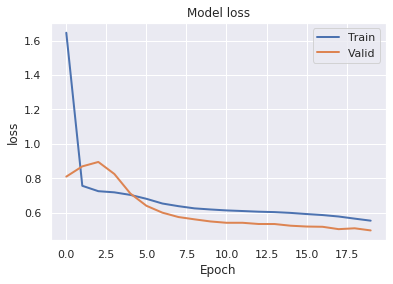

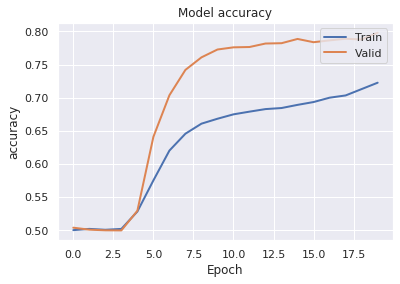

In [8]:
sns.set()

for graph in ['loss', 'accuracy']:
    
    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')
    
    plt.legend(loc='upper right')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')
    
    plt.show()

In [10]:
ratio_true_false = 1
event_threshold = 0.5

def get_siamese_ypred(X_train, X_test, y_train, y_test):
    
    X_true = X_train[np.where(y_train==True)[0],:,:]
    X_false = X_train[np.where(y_train==False)[0],:,:]
    idx = np.random.randint(X_false.shape[0], size=X_true.shape[0]*ratio_true_false)
    X_false = X_false[idx]
    X_train = np.concatenate((X_false,X_true), axis=0)
    
    y_pred = np.zeros((X_test.shape[0],1))
    
    for i, event in enumerate(X_test):
        
        event = event.reshape(1, event.shape[0], event.shape[1])
        event_array = np.repeat(event, X_train.shape[0], axis=0)
        
        y_event = model.predict([X_train, event_array], batch_size=batch)
        
        y_event_false = y_event[:X_false.shape[0]]
        y_event_false[y_event_false>=event_threshold] = False # 
        y_event_false[y_event_false<event_threshold] = True # if similarity with a false event is below threshold it is a true event
        
        y_event_true = y_event[X_false.shape[0]:]
        y_event_true[y_event_true>=event_threshold] = True # 
        y_event_true[y_event_true<event_threshold] = False # if similarity with a true event is below threshold it is a false event
        
        y_event = np.concatenate((y_event_false,y_event_true), axis=0)
        
        y_pred[i] = np.sum(y_event)/y_event.shape[0]
        
        #print(y_pred[i])
        #plt.hist(y_event, bins=30)
        #plt.show()
        #display.display(plt.gcf())
        #display.clear_output(wait=True)
        #time.sleep(1)
        
        del y_event
        
    return y_pred
    
        
y_pred_siamese = get_siamese_ypred(X_val, X_test, y_val, y_test) #cambiado train val

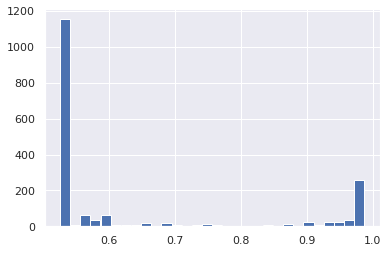

Siamese model: 1.535, 0.266, 0.173


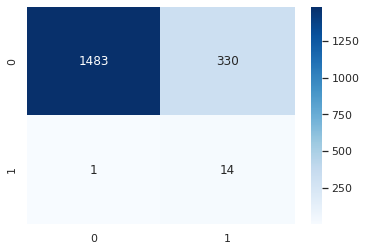

In [21]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.0001
classification_threshold = 0.935

def evaluate(name, y_pred):
    
    y_pred = (y_pred >= classification_threshold).reshape(-1,1)
    
    #rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]
    
    mse = mean_squared_error(y_test_mse, y_pred_mse)
    
    y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)
    
    f_beta = fbeta_score(y_real_bool, y_pred, 2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting with model
plt.hist(y_pred_siamese, bins=30)
plt.show()
evaluate("Siamese model:", y_pred_siamese)

Constant prediction: 6.375, 0.253, 0.040


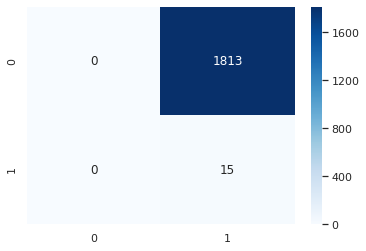

Predicting last value: 0.429, 0.221, 0.516


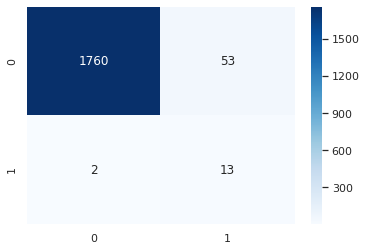

In [22]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.0001

def evaluate(name, y_pred):
    
    #rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]
    
    mse = mean_squared_error(y_test_mse, y_pred_mse)
    
    y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)
    
    f_beta = fbeta_score(y_real_bool, y_pred, 2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate("Constant prediction:", y_constant)

#Predicting last value
y_last = X_test[:,-1,1]
tmp = np.array([-6]).reshape(-1,1)
tmp = y_scaler.transform(tmp)
tmp = tmp[0,0]
y_last = (y_last > tmp).reshape(-1,1)
evaluate("Predicting last value:", y_last)

Predicting last value: 15.978, 8.243, 0.516


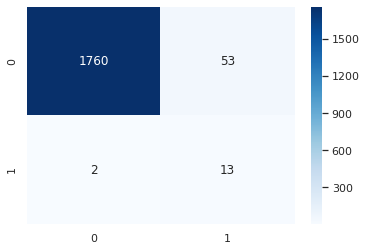

In [23]:
#Predicting last value
def recurrent_evaluate(name, y_pred):
    
    #Scaling both real predicted
    y_pred_scaled = y_scaler.inverse_transform(y_pred)
    y_real_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #boolean data
    y_pred_bool = (y_pred_scaled >= -6.0).reshape(-1,1)
    y_real_bool = (y_real_scaled >= -6.0).reshape(-1,1)
    f_beta = fbeta_score(y_real_bool, y_pred_bool, 2)
    
    #getting predictions greater than -6.0 in real data (y_real_scaled)
    y_pred_mse = y_pred_scaled[np.where(y_real_scaled >= -6.0)]
    y_real_mse = y_real_scaled[np.where(y_real_scaled >= -6.0)]
    mse = mean_squared_error(y_real_mse, y_pred_mse)
    
    #F-beta score
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    #Confusion matrix
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred_bool), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    
y_last = X_test[:,-1,1].reshape(-1,1)
y_bool_2 = recurrent_evaluate("Predicting last value:", y_last)

# EXTRA

In [ ]:
# From low to high risk
'''
low_to_high = []
for event, risk in zip(X,y):
    if(event[-1,1]<threshold_scaled and risk>=threshold_scaled):
        low_to_high.append(True)
    else:
        low_to_high.append(False)
y = np.array(low_to_high).reshape(-1,1)
'''

In [ ]:
#Sampling pairs
'''
def get_samples(X, y, n_pairs):
    
    X_true = X[np.where(y==True)[0],:,:]
    X_false = X[np.where(y==False)[0],:,:]
    print(X_true.shape, X_false.shape)
    
    idx_false = np.random.randint(X_false.shape[0], size=X_true.shape[0])
    X_false = X[idx_false,:,:]
    print(X_true.shape, X_false.shape)
    
    X_sample = np.concatenate((X_true, X_false), axis=0)
    print(X_sample.shape)
    
    idx_left = np.random.randint(X_sample.shape[0], size=X_sample.shape[0]*100)
    idx_right = np.random.randint(X_sample.shape[0], size=X_sample.shape[0]*100)
    X_left = X_sample[idx_left,:,:]
    X_right = X_sample[idx_right,:,:]
    
    high_cond = X_sample.shape[0] // 2
    idx_left_high = (idx_left < high_cond)
    idx_right_high = (idx_right < high_cond)
    y = (idx_left_high==idx_right_high).reshape(-1,1)
    print(np.sum(y),y.shape[0])
        
    return X_left, X_right, y
'''